In [1]:
"""
BAYESIAN SPECTROSCOPIC MASS ESTIMATOR (MADE) USING A BAYESIAN NEURAL NETWORK 
WITH APOKASC-TGAS DR14 TRAINING DATA
"""
%matplotlib inline 
from scipy.stats import kde
import scipy
import CalcBNN as cbnn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read APOGEE-TGAS data

In [2]:
# Read data file ("location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff","teff_err","logg","logg_err",
#        "m_h","m_h_err","alpha_m","alpha_m_err"],elarrdef,elarrdef_err,["ra_gaia","dec_gaia","ra_error","dec_error","parallax","parallax_error","pmra","pmra_error","pmdec",
#        "pmdec_error","meandist","diststd","lncanmass","elncanmass","lncanage","elncanage","kepmass","kepmass68L",
#        "kepmass68U","kepmass95L","kepmass95U","kepage","kepage68L","kepage68U","kepage95L","kepage95U",
#        "kepevstate")
datafile = "../data/apogee/APOGEE_TGAS_DR14_supp_keplercannon_masses_ages.csv"
dataAll  = pd.read_csv(datafile,header=0,index_col=0) 
nstars   = len(dataAll)  
                
print("The number of stars in the APOGEE-TGAS DR14 sample is:")
print(nstars)         

The number of stars in the APOGEE-TGAS DR14 sample is:
10074


# Train BNN on APOKASC-TGAS subsample

## Select APOKASC-TGAS subsample of APOGEE-TGAS DR14 stars

In [3]:
index       = dataAll["kepmass"]>-9999
print("Found "+str(np.sum(index))+" stars with Kepler masses.")
dataKepmass = dataAll[:][index]

Found 1312 stars with Kepler masses.


## Examine data

### Spearman correlation coefficient of spectral parameters versus mass

In [4]:
data = np.column_stack((dataKepmass["logg"].values,dataKepmass["teff"].values,dataKepmass["m_h"].values,
                        dataKepmass["[C/M]"].values,dataKepmass["[CI/M]"].values,
                        dataKepmass["[N/M]"].values,dataKepmass["[O/M]"].values,
                        dataKepmass["[Na/H]"].values,dataKepmass["[Mg/M]"].values,
                        dataKepmass["[Al/H]"].values,dataKepmass["[Si/M]"].values,
                        dataKepmass["[P/H]"].values,dataKepmass["[S/M]"].values,
                        dataKepmass["[K/H]"].values,dataKepmass["[Ca/M]"].values,
                        dataKepmass["[Ti/M]"].values,dataKepmass["[TiII/M]"].values,
                        dataKepmass["[V/H]"].values,dataKepmass["[Cr/H]"].values,
                        dataKepmass["[Mn/H]"].values,dataKepmass["[Co/H]"].values,
                        dataKepmass["[Ni/H]"].values,dataKepmass["[Cu/H]"].values,
                        dataKepmass["[Ge/H]"].values,dataKepmass["[Ce/H]"].values,
                        dataKepmass["[Rb/H]"].values,dataKepmass["[Y/H]"].values,
                        dataKepmass["[Nd/H]"].values))

labels = ["log g",r"$T_{\mathrm{eff}}$","[M/H]","[C/M]","[CI/M]","[N/M]","[O/M]","[Na/H]","[Mg/M]","[Al/H]","[Si/M]",\
          "[P/H]","[S/M]","[K/H]","[Ca/M]","[Ti/M]","[TiII/M]","[V/H]","[Cr/H]","[Mn/H]","[Co/H]","[Ni/H]","[Cu/H]","[Ge/H]","[Rb/H]",\
          "[Ge/H]","[Ce/H]","[Rb/H]","[Y/H]","[Nd/H]"]

# Omit spectral labels with -9999
ndata,nvar = np.shape(data)
good       = np.ones(nvar,dtype=bool)
for jvar in range(nvar):
    if (np.sum(data[:,jvar]==-9999)>0):
        good[jvar]=False
print("Kept "+str(np.sum(good))+" spectral labels.")
data   = data[:,good]
labels = [labels[i] for i in np.arange(nvar)[good] ]

# Calculate Spearman correlation coefficients
spearman = np.zeros([np.sum(good),2])
for jvar in range(np.sum(good)):
    x = data[:,jvar]
    y = dataKepmass["kepmass"].values
    spearman[jvar,:] = scipy.stats.spearmanr(x,y)
        
print("Spearman rho and p-values:")
print(spearman)

Kept 16 spectral labels.
Spearman rho and p-values:
[[ 2.95804125e-001  6.62732190e-028]
 [ 5.11825437e-001  1.67290882e-088]
 [ 4.76611646e-001  2.30734843e-075]
 [-7.41782044e-001  1.49533339e-229]
 [-7.42701930e-001  2.03799244e-230]
 [ 7.09187945e-001  4.32107292e-201]
 [-6.77817540e-001  3.35937717e-177]
 [-7.61577817e-001  4.88686972e-249]
 [-4.42167989e-001  6.47759362e-064]
 [ 1.34167550e-001  1.07608058e-006]
 [-5.19678844e-001  1.19484290e-091]
 [-4.00706732e-001  8.91074928e-052]
 [ 9.75831107e-003  7.23989062e-001]
 [ 5.08128254e-001  4.74627102e-087]
 [-2.69149690e-001  3.29327951e-023]
 [-5.42688361e-001  2.33954485e-101]]


## Build neural network

### Create training set and independent testing set

In [5]:
# Select neural network inputs and errors
inputs = np.column_stack((dataKepmass["logg"].values,dataKepmass["teff"].values,dataKepmass["m_h"].values,
                        dataKepmass["[C/M]"].values,dataKepmass["[CI/M]"].values,dataKepmass["[N/M]"].values,
                        dataKepmass["[O/M]"].values,dataKepmass["[Mg/M]"].values,dataKepmass["[Si/M]"].values,
                        dataKepmass["[P/H]"].values,dataKepmass["[K/H]"].values,dataKepmass["[Ti/M]"].values,
                        dataKepmass["[Mn/H]"].values,dataKepmass["[Co/H]"].values,dataKepmass["[Ni/H]"].values))
#inputs = np.column_stack((dataKepmass["logg"].values,dataKepmass["teff"].values,dataKepmass["m_h"].values,
#                          dataKepmass["[C/M]"].values,dataKepmass["[N/M]"].values,dataKepmass["[O/M]"].values))
ninputs = len(inputs[0,:])
print "Number of inputs: ", ninputs

errInputs = np.column_stack((dataKepmass["logg_err"].values,dataKepmass["teff_err"].values,
                             dataKepmass["m_h_err"].values,dataKepmass["err_[C/M]"].values,
                             dataKepmass["err_[CI/M]"].values,dataKepmass["err_[N/M]"].values,
                             dataKepmass["err_[O/M]"].values,dataKepmass["err_[Mg/M]"].values,
                             dataKepmass["err_[Si/M]"].values,dataKepmass["err_[P/H]"].values,
                             dataKepmass["err_[K/H]"].values,dataKepmass["err_[Ti/M]"].values,
                             dataKepmass["err_[Mn/H]"].values,dataKepmass["err_[Co/H]"].values,
                             dataKepmass["err_[Ni/H]"].values))  
#errInputs = np.column_stack((dataKepmass["logg_err"].values,dataKepmass["teff_err"].values,
#                             dataKepmass["m_h_err"].values,dataKepmass["err_[C/M]"].values,
#                             dataKepmass["err_[N/M]"].values,dataKepmass["err_[O/M]"].values))

# Select neural network target and errors
targets    = np.column_stack((dataKepmass["kepmass"].values,))
errTargets = np.column_stack(((dataKepmass["kepmass68U"].values - dataKepmass["kepmass68L"].values)/2.,))
ntargets = len(targets[0,:])
print "Number of targets: ", ntargets

# Split intro testing and training samples with set random seed
np.random.seed(10)
ftest           = 0.2
nobs            = inputs.shape[0]
itest           = np.random.randint(0,nobs-1,np.int(nobs*ftest))
booltest        = np.zeros([nobs],dtype=bool)
booltest[itest] = True
inputsTest      = inputs[booltest,:]
errInputsTest   = errInputs[booltest,:]
targetsTest     = targets[booltest,:]
errTargetsTest  = errTargets[booltest,:]
inputsTrain     = inputs[~booltest,:]
errInputsTrain  = errInputs[~booltest,:]
targetsTrain    = targets[~booltest,:]
errTargetsTrain = errTargets[~booltest,:]

ntrain = len(inputsTrain)
ntest  = len(inputsTest)
print "Number of training samples: ", ntrain
print "Number of testing samples: ", ntest

Number of inputs:  15
Number of targets:  1
Number of training samples:  1069
Number of testing samples:  243


### Analyses dependence of errors in mass on mass

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.scatter(targets,errTargets/targets,marker='o',color="red")
errTargetsRatioMu = np.mean(errTargets/targets)
print(errTargetsRatioMu)
plt.plot([np.min(targets),np.max(targets)],[errTargetsRatioMu,errTargetsRatioMu],':k')
plotfile = "../plots/apogee/mass/errMass_mass.eps"
fig.savefig(plotfile,format='eps',bbox_inches='tight')

### Instantiate class

In [6]:
bnn = cbnn.CalcBNN()

### Train neural network

In [7]:
# Number of neurons per hidden layer
neuronsPerHiddenlayer = 30

# Whether to use NUTS or ADVI sampler
sampler               = "nuts"

# Number of samples tro draw from posterior
nsamp                 = 5000

# Pickle file for storing model
tracedir = "../results/apogee/mass/"
bnnmodelpkl = tracedir+"bnn_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".pkl"
print(bnnmodelpkl)

# Directory for storing plots
plotdir     = "../plots/apogee/mass/"
print(plotdir)
ncores      = 2

# Train BNN
#bnn.trainBNN(inputsTrain,errInputsTrain,targetsTrain,errTargetsTrain,
#             neuronsPerHiddenlayer,sampler,nsamp,bnnmodelpkl,plotdir,
#             ncores,viewBNN=False)

../results/apogee/mass/bnn_nuts_ninputs15_nhid30_nsamp5000.pkl
../plots/apogee/mass/


### Calculate posterior predictive distributions for training set

In [12]:
# Number of posterior predictive samples
nppc = 5000  

# Apply model
out = bnn.calcPostPredSamplesTest(bnnmodelpkl,inputsTrain,errInputsTrain,
                                  targetsTrain,errTargetsTrain,nppc,plotdir)

inputsTrainTrueMu   = out[0]["InputsTrueMu"]
inputsTrainTrueSig  = out[0]["InputsTrueSig"]
targetsTrainTrueMu  = out[0]["TargetsTrueMu"]
targetsTrainTrueSig = out[0]["TargetsTrueSig"]

### Calculate posterior predictive distributions for testing set

100%|██████████| 5000/5000 [00:31<00:00, 157.35it/s]

Reduced chi-squared (only valid for testing set) = 0.8784976523350024
Mean p-value = 0.1084
Standard deviation p-value = 0.066


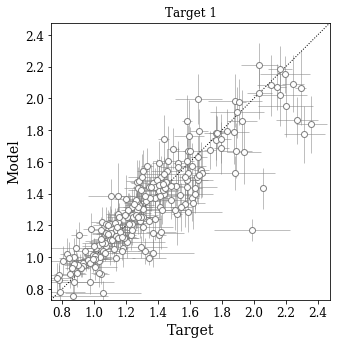

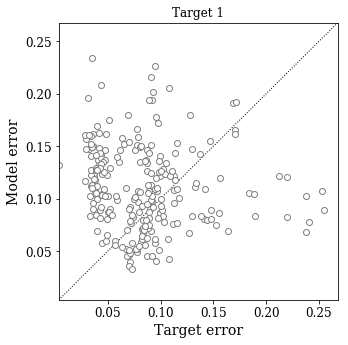

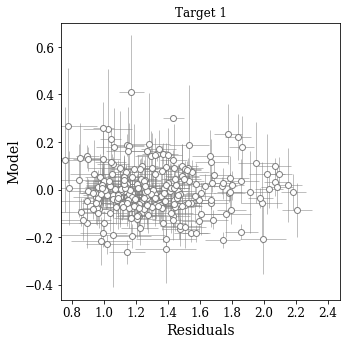

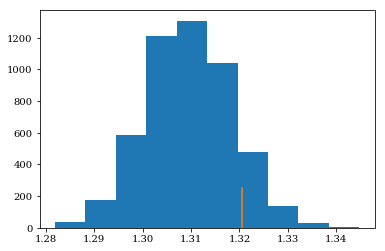

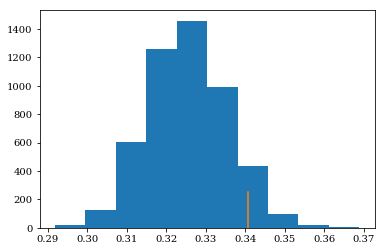

In [13]:
outTest = bnn.calcPostPredSamplesTest(bnnmodelpkl,inputsTest,errInputsTest,
                                      targetsTest,errTargetsTest,nppc,plotdir)

inputsTestTrueMu   = outTest[0]["InputsTrueMu"]
inputsTestTrueSig  = outTest[0]["InputsTrueSig"]
targetsTestTrueMu  = outTest[0]["TargetsTrueMu"]
targetsTestTrueSig = outTest[0]["TargetsTrueSig"]

### More plots comparing models for combined training and testing samples

In [29]:
# Calculate residuals
resTrain  = (targetsTrain-targetsTrainTrueMu)/targetsTrain
eResTrain = np.sqrt(targetsTrainTrueSig**2./targetsTrain**2. + errTargetsTrain**2.*targetsTrainTrueMu**2./targetsTrain**4)
resTest   = (targetsTest-targetsTestTrueMu)/targetsTest
eResTest  = np.sqrt(targetsTestTrueSig**2./targetsTest**2. + errTargetsTest**2.*targetsTestTrueMu**2./targetsTest**4)
indexTrain = abs(resTrain)>0.25
indexTest  = abs(resTest)>0.25

../plots/apogee/mass/massnnet_nuts_ninputs15_nhid30_nsamp5000.eps


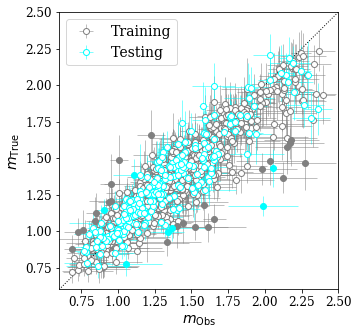

In [61]:
# Create plot comparing masses, highlighting outliers
plt.rc('font',family='serif')
mmin = 0.6
mmax = 2.5
fig0    = plt.figure(figsize=(5,5.1))    
plt.errorbar(targetsTrain[~indexTrain],targetsTrainTrueMu[~indexTrain],
             xerr=errTargetsTrain[~indexTrain],yerr=targetsTrainTrueSig[~indexTrain],
             fmt='o',color='gray',linewidth=0.5,mfc='white',label="Training")
plt.errorbar(targetsTest[~indexTest],targetsTestTrueMu[~indexTest],
             xerr=errTargetsTest[~indexTest],yerr=targetsTestTrueSig[~indexTest],
             fmt='o',color='cyan',linewidth=0.5,mfc='white',label="Testing")
plt.errorbar(targetsTrain[indexTrain],targetsTrainTrueMu[indexTrain],
             xerr=errTargetsTrain[indexTrain],yerr=targetsTrainTrueSig[indexTrain],
             fmt='o',color='gray',linewidth=0.5)
plt.errorbar(targetsTest[indexTest],targetsTestTrueMu[indexTest],
             xerr=errTargetsTest[indexTest],yerr=targetsTestTrueSig[indexTest],
             fmt='o',color='cyan',linewidth=0.5)
plt.legend(fontsize=14)
plt.plot([mmin,mmax],[mmin,mmax],':k',linewidth=1)
plt.xlabel(r'$m_{\mathrm{Obs}}$', fontsize=14)
plt.ylabel(r'$m_{\mathrm{True}}$', fontsize=14)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12) 
plt.xlim([mmin,mmax])
plt.ylim([mmin,mmax])
plotfile = plotdir+"massnnet_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".eps"
print(plotfile)
fig0.savefig(plotfile,format='eps',bbox_inches='tight',rasterized=True)

../plots/apogee/mass/emassnnet_nuts_ninputs15_nhid30_nsamp5000.eps


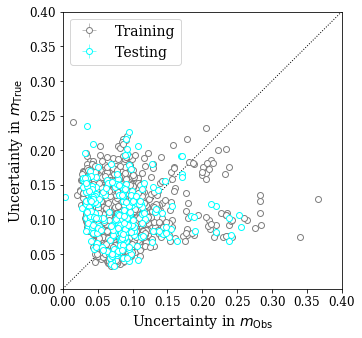

In [51]:
# Create plot comparing errors in masses, highlighting outliers
plt.rc('font',family='serif')
errmmin = 0.0
errmmax = 0.4
fig0    = plt.figure(figsize=(5,5.1))    
plt.errorbar(errTargetsTrain,targetsTrainTrueSig,xerr=0.,yerr=0.,
             fmt='o',color='gray',linewidth=0.5,mfc='white',label="Training")
plt.errorbar(errTargetsTest,targetsTestTrueSig,xerr=0.,yerr=0.,
             fmt='o',color='cyan',linewidth=0.5,mfc='white',label="Testing")
plt.legend(fontsize=14)
plt.plot([errmmin,errmmax],[errmmin,errmmax],':k',linewidth=1)
plt.xlabel(r'Uncertainty in $m_{\mathrm{Obs}}$', fontsize=14)
plt.ylabel(r'Uncertainty in $m_{\mathrm{True}}$', fontsize=14)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12) 
plt.xlim([errmmin,errmmax])
plt.ylim([errmmin,errmmax])
plotfile = plotdir+"emassnnet_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".eps"
print(plotfile)
fig0.savefig(plotfile,format='eps',bbox_inches='tight',rasterized=True)

../plots/apogee/mass/massnnet_residuals_nuts_ninputs15_nhid30_nsamp5000.pdf


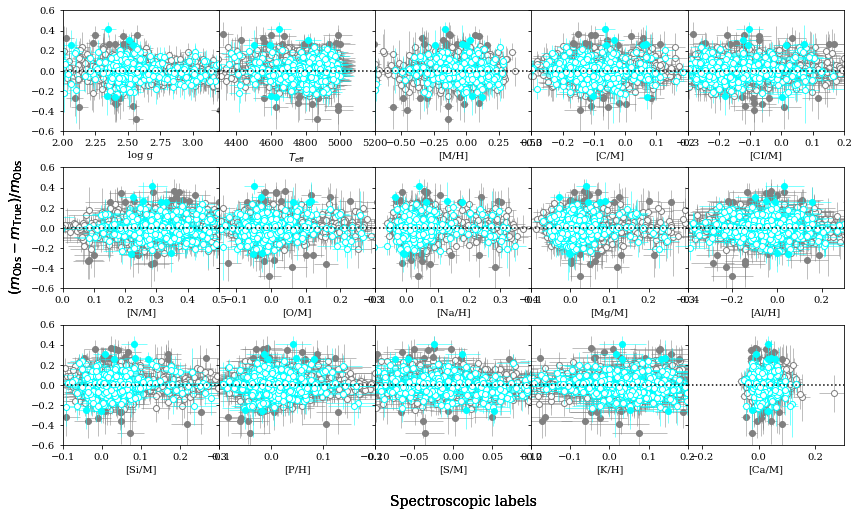

In [67]:
# Plots examining residuals against inputs
nr = 3
nc = 5
plt.rc('font',family='serif')  
xlims = np.array([[2.0,3.2],[4300.,5200.],[-0.7,0.5],[-0.3,0.2],[-0.3,0.2],[0.0,0.5],[-0.15,0.3],[-0.1,0.4],
                  [-0.1,0.3],[-0.4,0.3],[-0.1,0.3],[-0.1,0.2],[-0.1,0.1],[-0.2,0.2],[-0.25,0.3],[-0.1,0.15]])
#xlims = np.array([[1.2,3.3],[4000.,5100.],[-1.0,0.6],[-0.75,0.3],[-0.9,0.8],[-0.3,0.6]])
labels = ["log g",r"$T_{\mathrm{eff}}$","[M/H]","[C/M]","[CI/M]","[N/M]","[O/M]","[Na/H]","[Mg/M]","[Al/H]","[Si/M]",\
          "[P/H]","[S/M]","[K/H]","[Ca/M]","[Ti/M]","[TiII/M]","[V/H]","[Cr/H]","[Mn/H]","[Co/H]","[Ni/H]","[Cu/H]","[Ge/H]","[Rb/H]",\
          "[Ge/H]","[Ce/H]","[Rb/H]","[Y/H]","[Nd/H]"]
#labels = ["log g",r"$T_{\mathrm{eff}}$","[M/H]","[C/M]","[N/M]","[O/M]"]
fig0,axarr = plt.subplots(nr,nc,figsize=(14,8),sharey=True)   
fig0.subplots_adjust(hspace=0.3,wspace=0)
jplots = 0
for jr in range(nr):
    for jc in range(nc):
        axarr[jr,jc].errorbar(inputsTrain[~indexTrain[:,0],jplots],resTrain[~indexTrain[:,0]],
                              xerr=errInputsTrain[~indexTrain[:,0],jplots],yerr=eResTrain[~indexTrain[:,0]],
                     fmt='o',color='gray',linewidth=0.5,mfc='white',label="Training",zorder=1)
        axarr[jr,jc].errorbar(inputsTest[~indexTest[:,0],jplots],resTest[~indexTest[:,0]],
                              xerr=errInputsTest[~indexTest[:,0],jplots],yerr=eResTest[~indexTest[:,0]],
                     fmt='o',color='cyan',linewidth=0.5,mfc='white',label="Testing",zorder=2)
        axarr[jr,jc].errorbar(inputsTrain[indexTrain[:,0],jplots],resTrain[indexTrain],
                              xerr=errInputsTrain[indexTrain[:,0],jplots],yerr=eResTrain[indexTrain],
                              fmt='o',color='gray',linewidth=0.5,zorder=1)
        axarr[jr,jc].errorbar(inputsTest[indexTest[:,0],jplots],resTest[indexTest],
                              xerr=errInputsTest[indexTest[:,0],jplots],yerr=eResTest[indexTest],
                              fmt='o',color='cyan',linewidth=0.5,zorder=2)
        axarr[jr,jc].plot(xlims[jplots,:],[0.0,0.0],':k',zorder=3)
        axarr[jr,jc].set_xlabel(labels[jplots],fontsize=10)
        axarr[jr,jc].set_xlim(xlims[jplots,:])
        axarr[jr,jc].set_ylim([-0.6,0.6])
        jplots += 1
    plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    plt.gcf().text(0.07,0.6,r"$(m_{\mathrm{Obs}}-m_{\mathrm{True}})/m_{\mathrm{Obs}}$",fontsize=14,rotation=90)
    plt.gcf().text(0.45,0.02,"Spectroscopic labels",fontsize=14)
plotfile = plotdir+"massnnet_residuals_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".pdf"
print(plotfile)
fig0.savefig(plotfile,format='pdf',bbox_inches='tight',dpi=80)

### Calculate posterior predictive distributions for comnined training and testing set

100%|██████████| 5000/5000 [01:50<00:00, 45.19it/s]

Reduced chi-squared (only valid for testing set) = 0.6195505997969982
Mean p-value = 0.0048
Standard deviation p-value = 0.0008


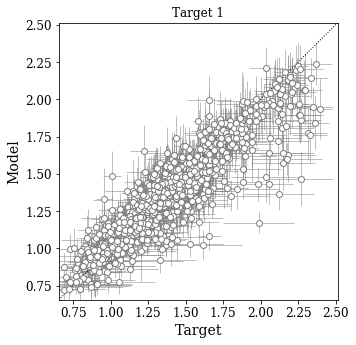

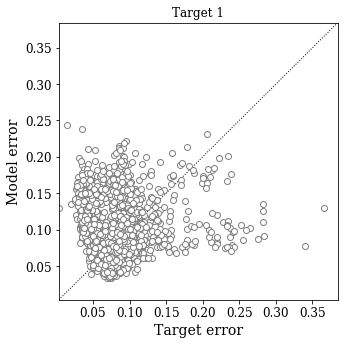

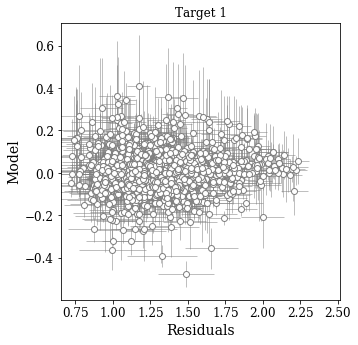

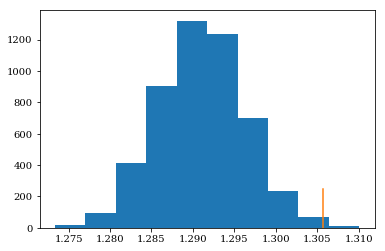

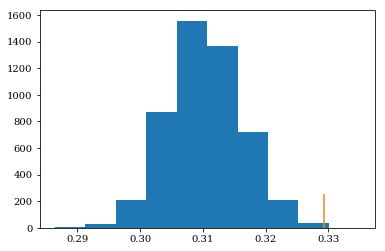

In [48]:
outComb = bnn.calcPostPredSamplesTest(bnnmodelpkl,inputs,errInputs,
                                      targets,errTargets,nppc,plotdir)

inputsTrueMu   = outComb[0]["InputsTrueMu"]
inputsTrueSig  = outComb[0]["InputsTrueSig"]
targetsTrueMu  = outComb[0]["TargetsTrueMu"]
targetsTrueSig = outComb[0]["TargetsTrueSig"]

../plots/apogee/mass/mass_spectral_corr_nuts_ninputs15_nhid30_nsamp5000.eps


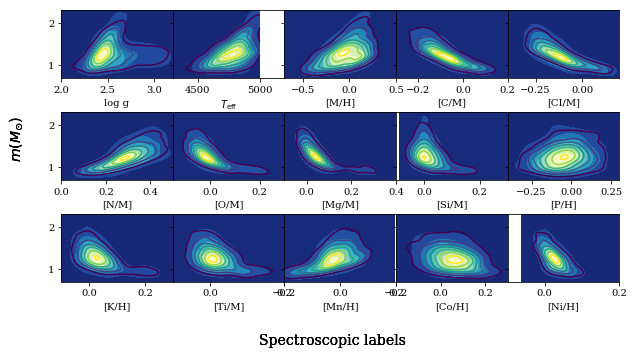

In [49]:
# Density plots of spectral parameters versus mass (with model)
nr = 3
nc = 5
plt.rc('font',family='serif')  
xlims = np.array([[2.0,3.2],[4300.,5200.],[-0.7,0.5],[-0.3,0.2],[-0.4,0.2],[0.0,0.5],[-0.15,0.3],[-0.1,0.4],
                  [-0.1,0.3],[-0.4,0.3],[-0.1,0.3],[-0.1,0.2],[-0.2,0.2],[-0.2,0.3],[-0.1,0.2],[-0.1,0.15]])
#xlims = np.array([[2.0,3.2],[4300.,5100.],[-0.7,0.5],[-0.3,0.2],[0.0,0.6],[-0.2,0.3]])
labels = ["log g",r"$T_{\mathrm{eff}}$","[M/H]","[C/M]","[CI/M]","[N/M]","[O/M]","[Mg/M]",\
          "[Si/M]","[P/H]","[K/H]","[Ti/M]","[Mn/H]","[Co/H]","[Ni/H]"]
#labels = ["log g",r"$T_{\mathrm{eff}}$","[M/H]","[C/M]","[N/M]","[O/M]"]
fig,axarr = plt.subplots(nr,nc,figsize=(10,5),sharey=True)   
fig.subplots_adjust(hspace=0.5,wspace=0)
jplots = 0
for jr in range(nr):
    for jc in range(nc):
        
        # Data
        x = inputs[:,jplots]
        y = dataKepmass["kepmass"].values
        k = kde.gaussian_kde([x,y])
        nbins = 100
        xi,yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        axarr[jr,jc].contourf(xi, yi, zi.reshape(xi.shape),cmap='YlGnBu_r')
        
        # Model
        xm = inputsTrueMu[:,jplots]
        ym = targetsTrueMu[:,0]
        km = kde.gaussian_kde([xm,ym])
        xmi,ymi = np.mgrid[xm.min():xm.max():nbins*1j, ym.min():ym.max():nbins*1j]
        zmi = km(np.vstack([xmi.flatten(), ymi.flatten()]))
        axarr[jr,jc].contour(xmi, ymi, zmi.reshape(xmi.shape))
        axarr[jr,jc].set_xlabel(labels[jplots],fontsize=10)
        axarr[jr,jc].set_xlim(xlims[jplots,:])
        axarr[jr,jc].set_ylim([0.7,2.3])
        
        jplots += 1
    plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    plt.gcf().text(0.05,0.55,r"$m (M_{\odot}$)",fontsize=14,rotation=90)
    plt.gcf().text(0.4,-0.05,"Spectroscopic labels",fontsize=14)
plotfile = plotdir+"mass_spectral_corr_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".eps"
print(plotfile)
fig.savefig(plotfile,format='eps',bbox_inches='tight')

### Save APOKASC-TGAS data set

In [50]:
# File header
header=np.hstack([["location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff","teff_err","logg",
                   "logg_err","m_h","m_h_err","alpha_m","alpha_m_err","ra_gaia","dec_gaia","ra_error",
                   "dec_error","parallax","parallax_error","pmra","pmra_error","pmdec","pmdec_error","annMass",
                   "eAnnMass","lncanmass","elncanmass","lncanage","elncanage","kepmass","kepmass68L",
                   "kepmass68U","kepmass95L","kepmass95U","kepage","kepage68L","kepage68U","kepage95L",
                   "kepage95U","kepevstate"]])
catalog = np.column_stack((dataKepmass["location_id"],dataKepmass["ra"],dataKepmass["dec"],dataKepmass["vlos"],
                           dataKepmass["evlos"],dataKepmass["j"],dataKepmass["ej"],dataKepmass["h"],
                           dataKepmass["eh"],dataKepmass["k"],dataKepmass["ek"],dataKepmass["teff"],
                           dataKepmass["teff_err"],dataKepmass["logg"],dataKepmass["logg_err"],dataKepmass["m_h"],
                           dataKepmass["m_h_err"],dataKepmass["alpha_m"],dataKepmass["alpha_m_err"],
                           dataKepmass["ra_gaia"],dataKepmass["dec_gaia"],dataKepmass["ra_error"],
                           dataKepmass["dec_error"],dataKepmass["parallax"],dataKepmass["parallax_error"],
                           dataKepmass["pmra"],dataKepmass["pmra_error"],dataKepmass["pmdec"],
                           dataKepmass["pmdec_error"],targetsTrueMu[:,0],targetsTrueSig[:,0],dataKepmass["lncanmass"],
                           dataKepmass["elncanmass"],dataKepmass["lncanage"],dataKepmass["elncanage"],
                           dataKepmass["kepmass"],dataKepmass["kepmass68L"],dataKepmass["kepmass68U"],
                           dataKepmass["kepmass95L"],dataKepmass["kepmass95U"],dataKepmass["kepage"],
                           dataKepmass["kepage68L"],dataKepmass["kepage68U"],dataKepmass["kepage95L"],
                           dataKepmass["kepage95U"],dataKepmass["kepevstate"]))
catalog = pd.DataFrame(data=catalog,index=None,columns=header)
datafile       = "../data/apogee/APOKASC_TGAS_supp_keplercannonann_masses_ages.csv"
catalog.to_csv(datafile,sep=',',na_rep='nan',float_format='%15.5e',columns=header,header=True,index=True)

(1312, 1)
